Prospective researcher beware, here lies a nerd hole. My goal here was to find latent factors that trend or mean revert well in crypto purely using returns and PCA. I dont know what im doing. I have not been able to find eigenportfolios which are stable, therefore none are tradable. I think crypto might be special, in that it's PCA'd eigenportfolios are inherently unstable and unintuitive, besides the market portfolio (PC-1). Greener pasteres are elsewhere

In [9]:
import pandas as pd

paths = {
	"binance": "/Users/ilyat/Documents/quant📈/ccxt_data/data/binance/ohlc/perps/combined_enriched.csv",
	"bybit": "/Users/ilyat/Documents/quant📈/ccxt_data/data/bybit/ohlc/perps/combined_enriched.csv",
	"hyperliquid": "/Users/ilyat/Documents/quant📈/ccxt_data/data/hyperliquid/ohlc/perps/combined_enriched.csv",
	"paradex": "/Users/ilyat/Documents/quant📈/ccxt_data/data/paradex/ohlc/perps/combined.csv",
}

df = pd.read_csv(paths['binance'])

In [10]:
# filter stables
import requests

# Fetch coin categories
categories_url = "https://api.coingecko.com/api/v3/coins/categories"
response = requests.get(categories_url)
categories = response.json()

# Find the 'Stablecoins' category
stablecoins_category = next((cat for cat in categories if cat['name'] == 'Stablecoins'), None)

if stablecoins_category:
	# Fetch coins in the 'Stablecoins' category
	stablecoins_url = f"https://api.coingecko.com/api/v3/coins/markets"
	params = {
		'vs_currency': 'usd',
		'category': stablecoins_category['id'],
		'order': 'market_cap_desc',
		'per_page': 250,
		'page': 1,
		'sparkline': False
	}
	response = requests.get(stablecoins_url, params=params)
	stablecoins = response.json()
	
	# Extract stablecoin symbols
	stablecoin_symbols = [coin['symbol'].upper() for coin in stablecoins]
	print(f"Found {len(stablecoin_symbols)} stablecoins in the category.")
	print(stablecoin_symbols[0:5])
else:
	print("Stablecoins category not found.")

# Filter out stable coins from the DataFrame
before_filter = df['symbol'].unique()
df = df[~df['symbol'].isin(stablecoin_symbols)]
after_filter = df['symbol'].unique()
print(f"Filtered out {len(before_filter) - len(after_filter)} stablecoins.")


Found 250 stablecoins in the category.
['USDT', 'USDC', 'USDS', 'USDE', 'DAI']
Filtered out 3 stablecoins.


In [11]:
df.columns


Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'market_cap', 'fundingRate', 'buy_volume_ratio', 'Buy_Trades',
       'Total_Trades'],
      dtype='object')

In [12]:
df = df[df.timestamp>'2021-01-01']

In [13]:
# # Filter by tag
# tags = pd.read_csv('./tags_2.csv')  # columns: coin,tag
# industry = tags[tags.tag=='meme_and_community']['coin']
# df = df[df.symbol.isin(industry)]

/Users/ilyat/finance-venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36015/398491914.py:176: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  w_tag   = w.groupby(tag_map, axis=1).sum().loc[plot_start:]


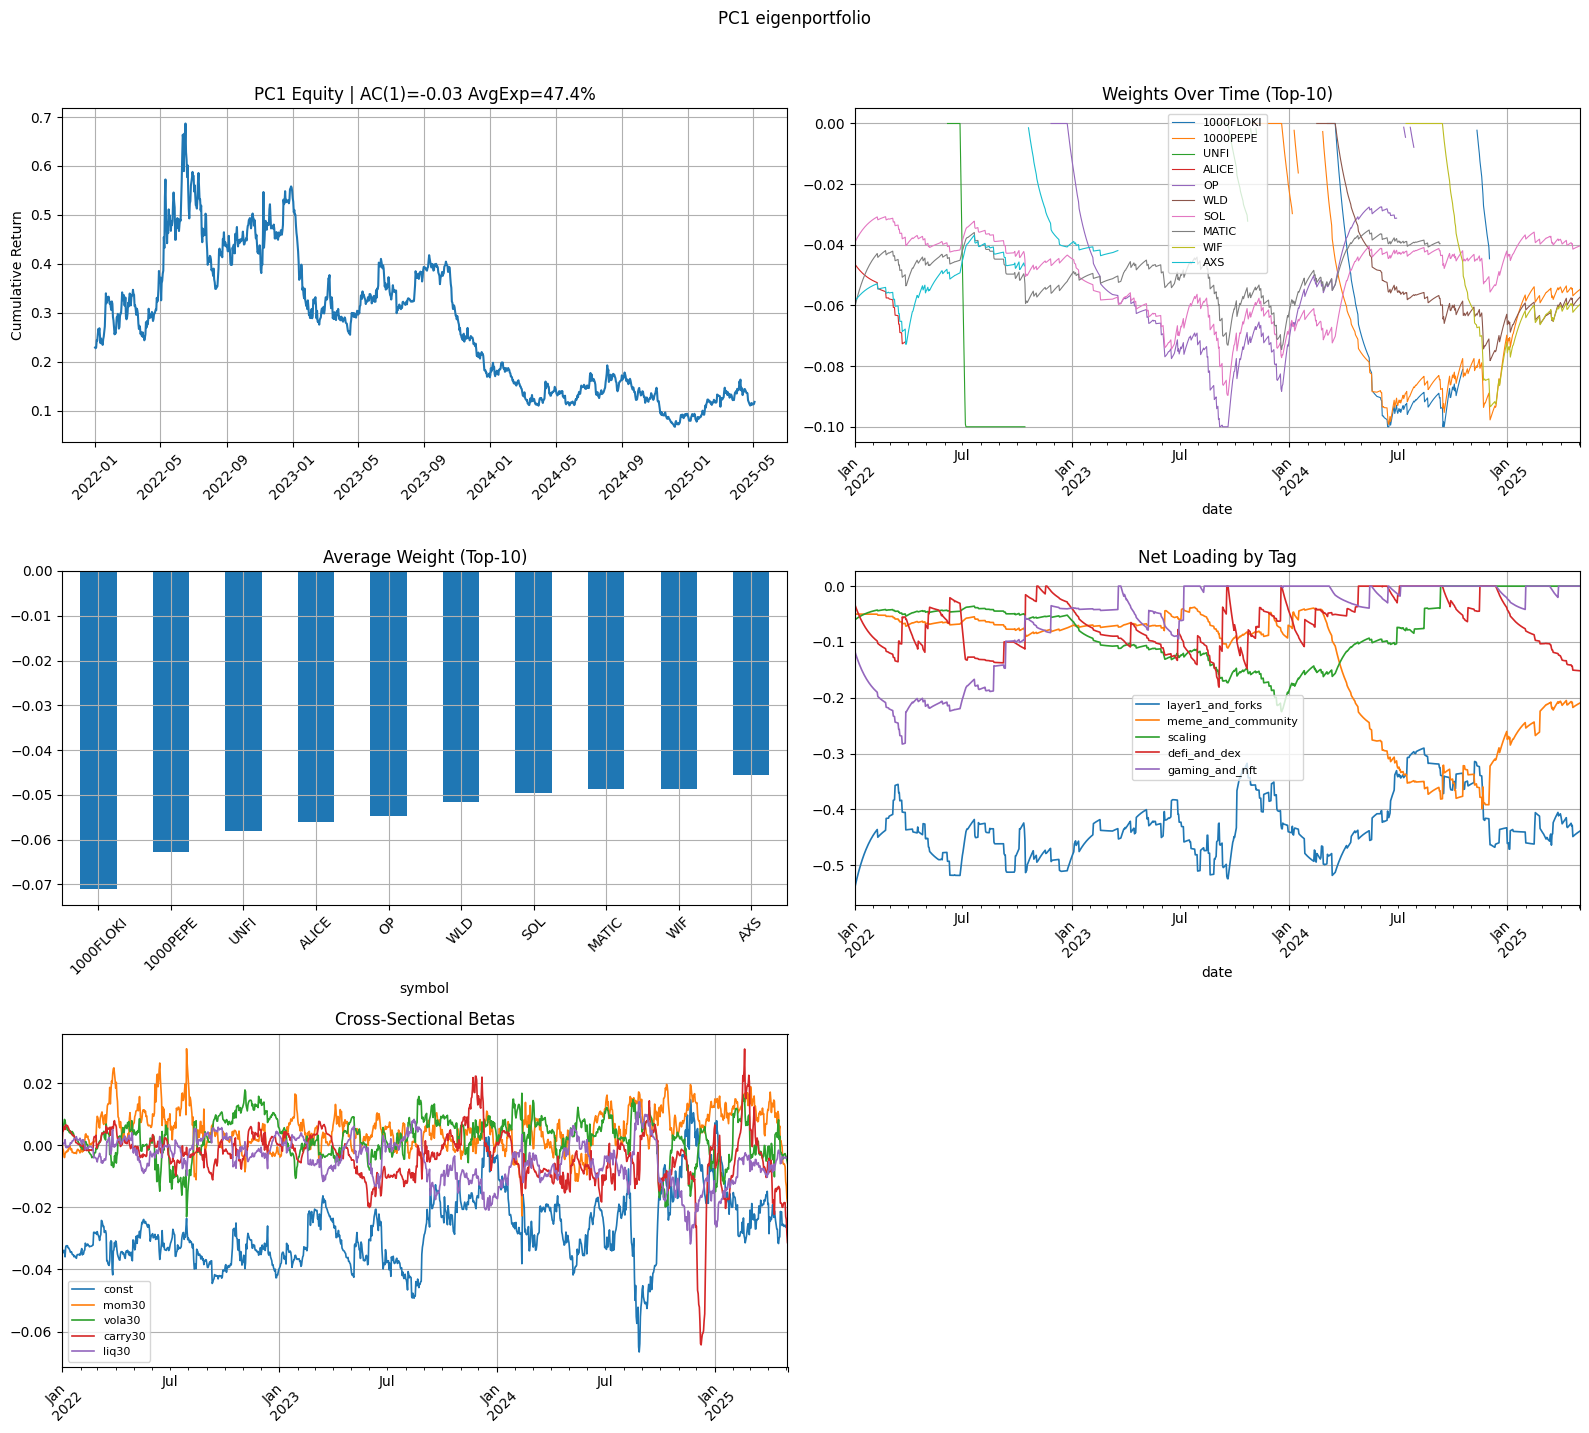

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36015/398491914.py:176: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  w_tag   = w.groupby(tag_map, axis=1).sum().loc[plot_start:]


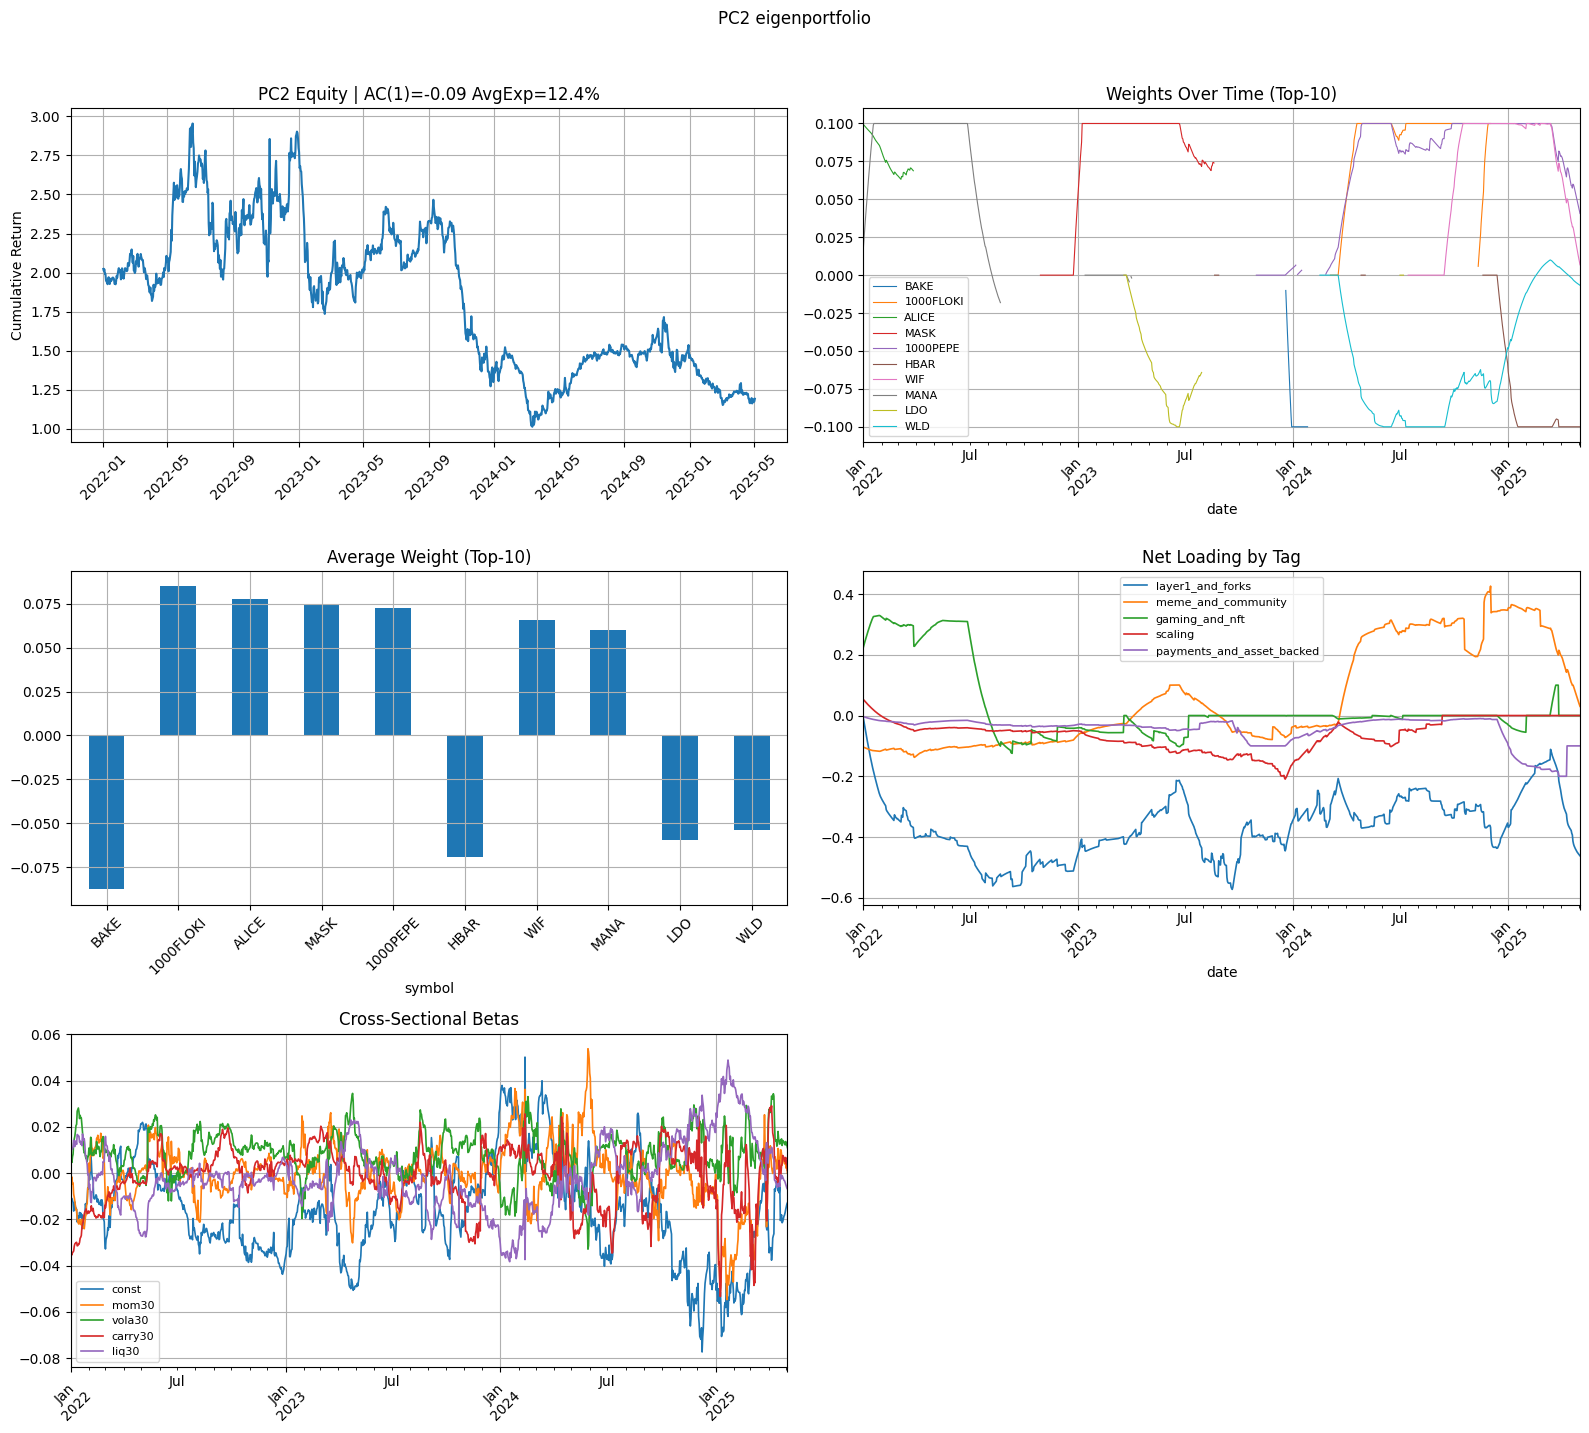

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36015/398491914.py:176: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  w_tag   = w.groupby(tag_map, axis=1).sum().loc[plot_start:]


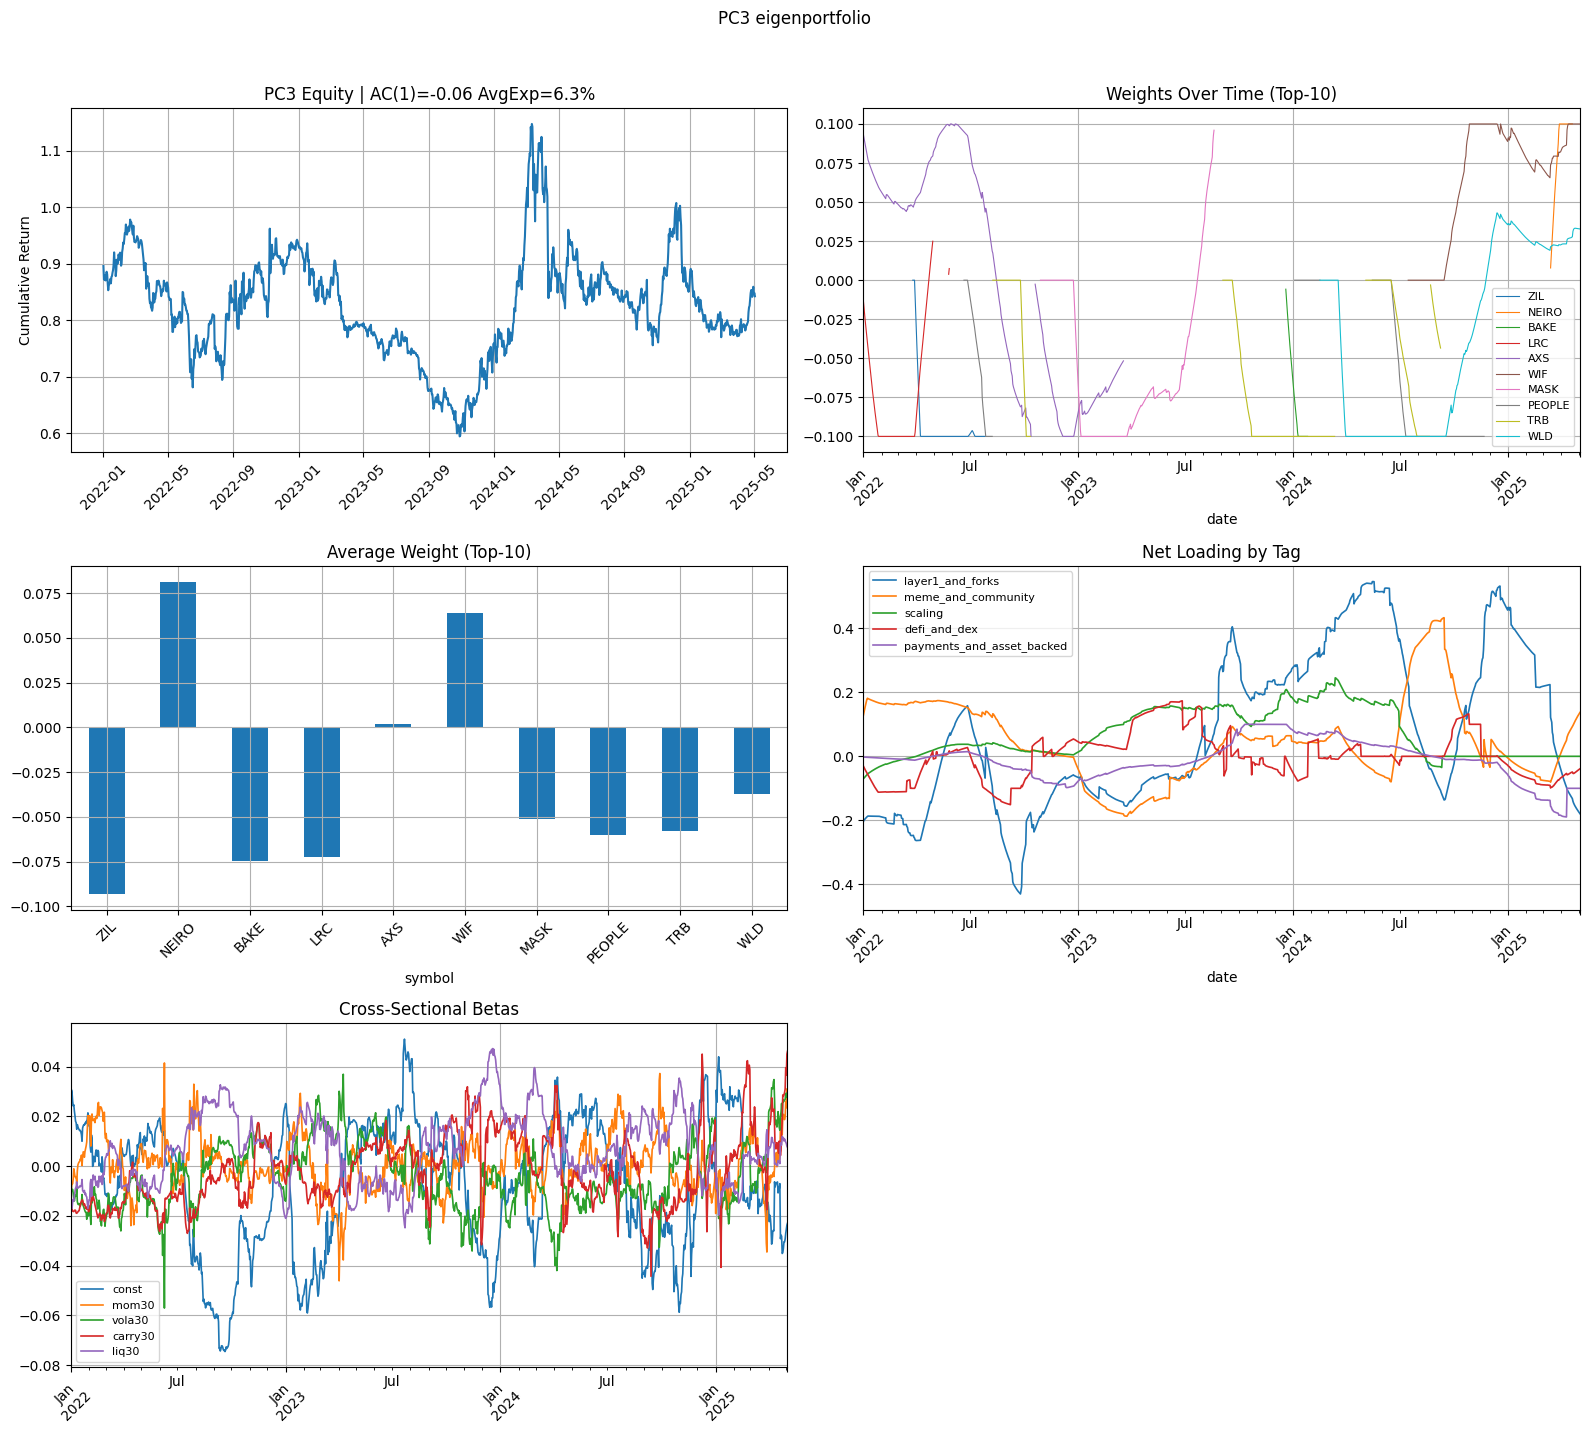

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36015/398491914.py:176: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  w_tag   = w.groupby(tag_map, axis=1).sum().loc[plot_start:]


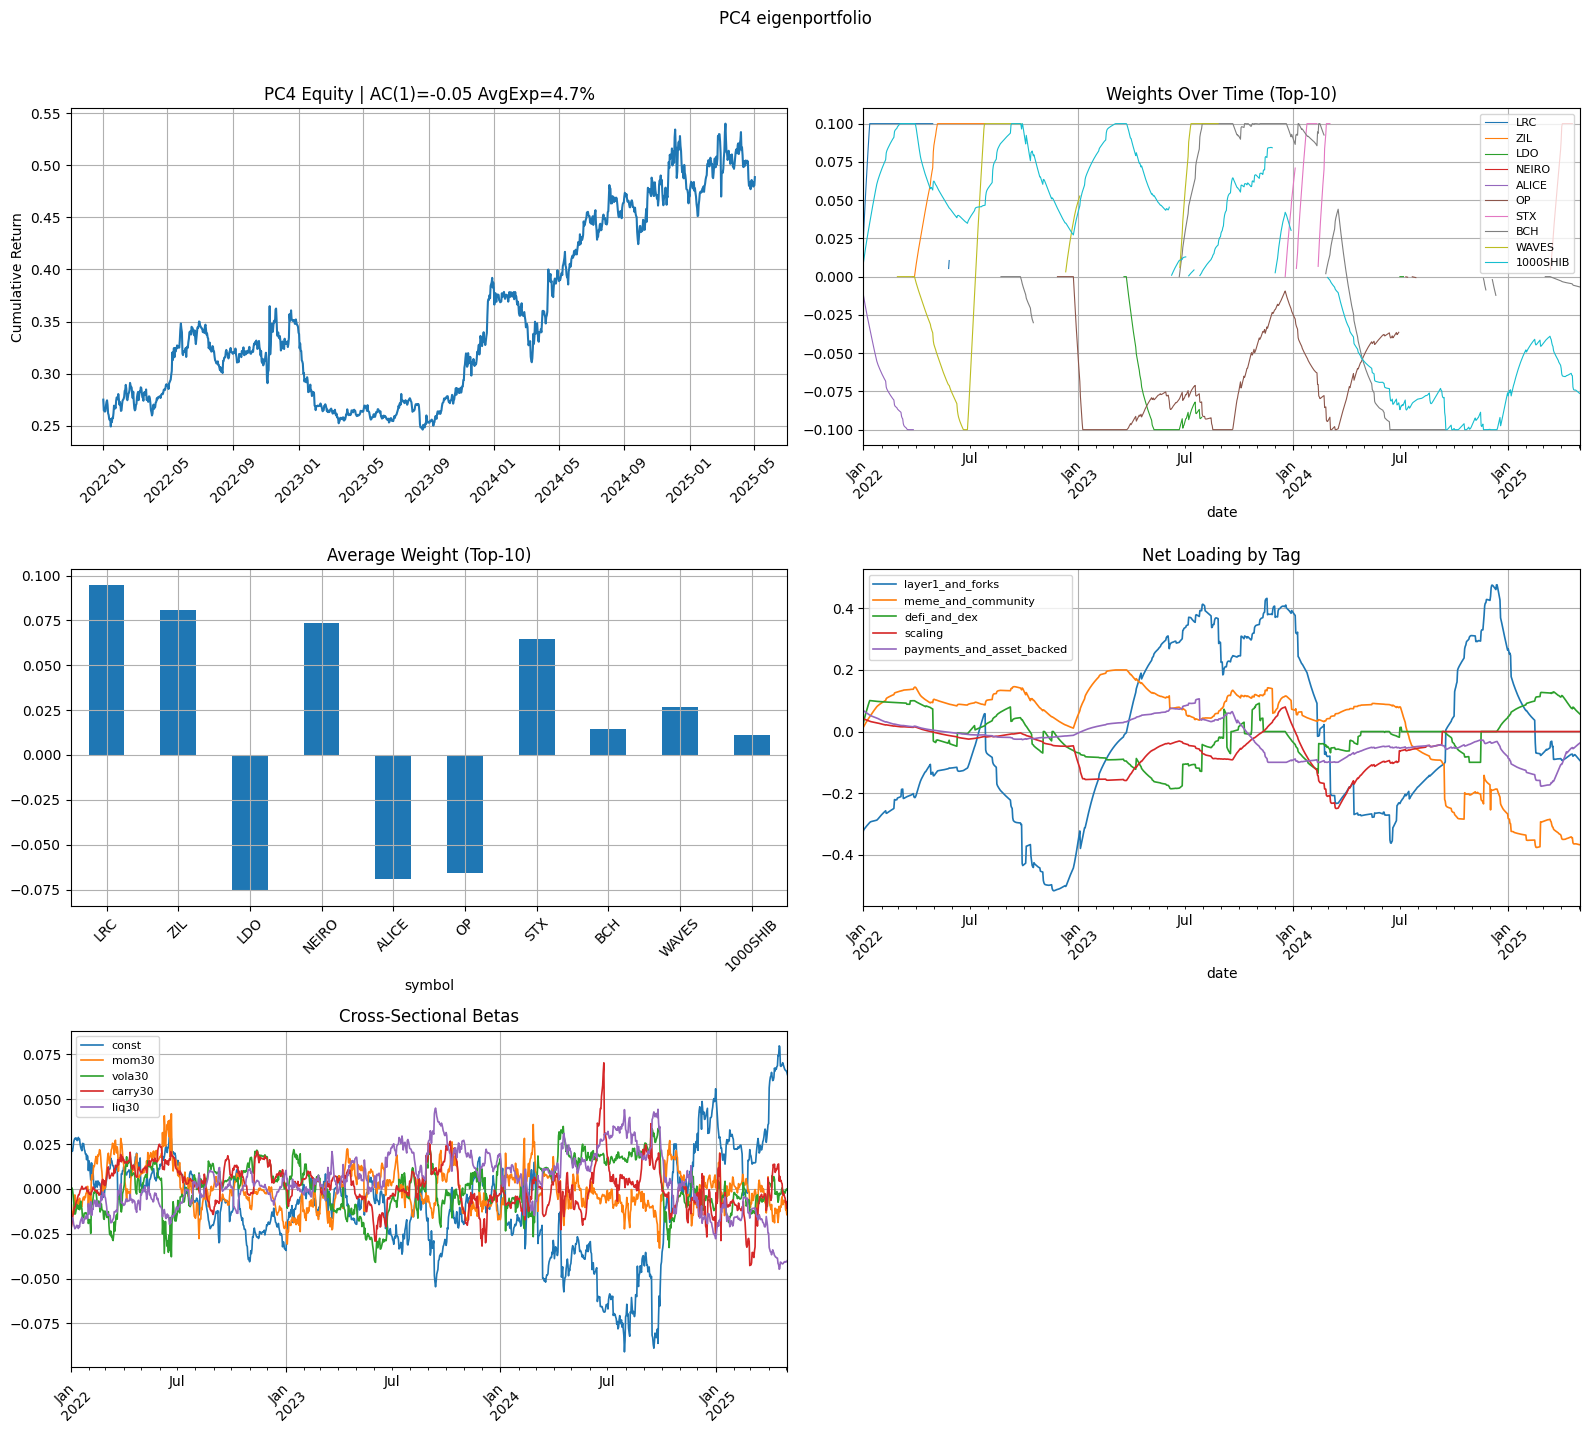

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36015/398491914.py:176: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  w_tag   = w.groupby(tag_map, axis=1).sum().loc[plot_start:]


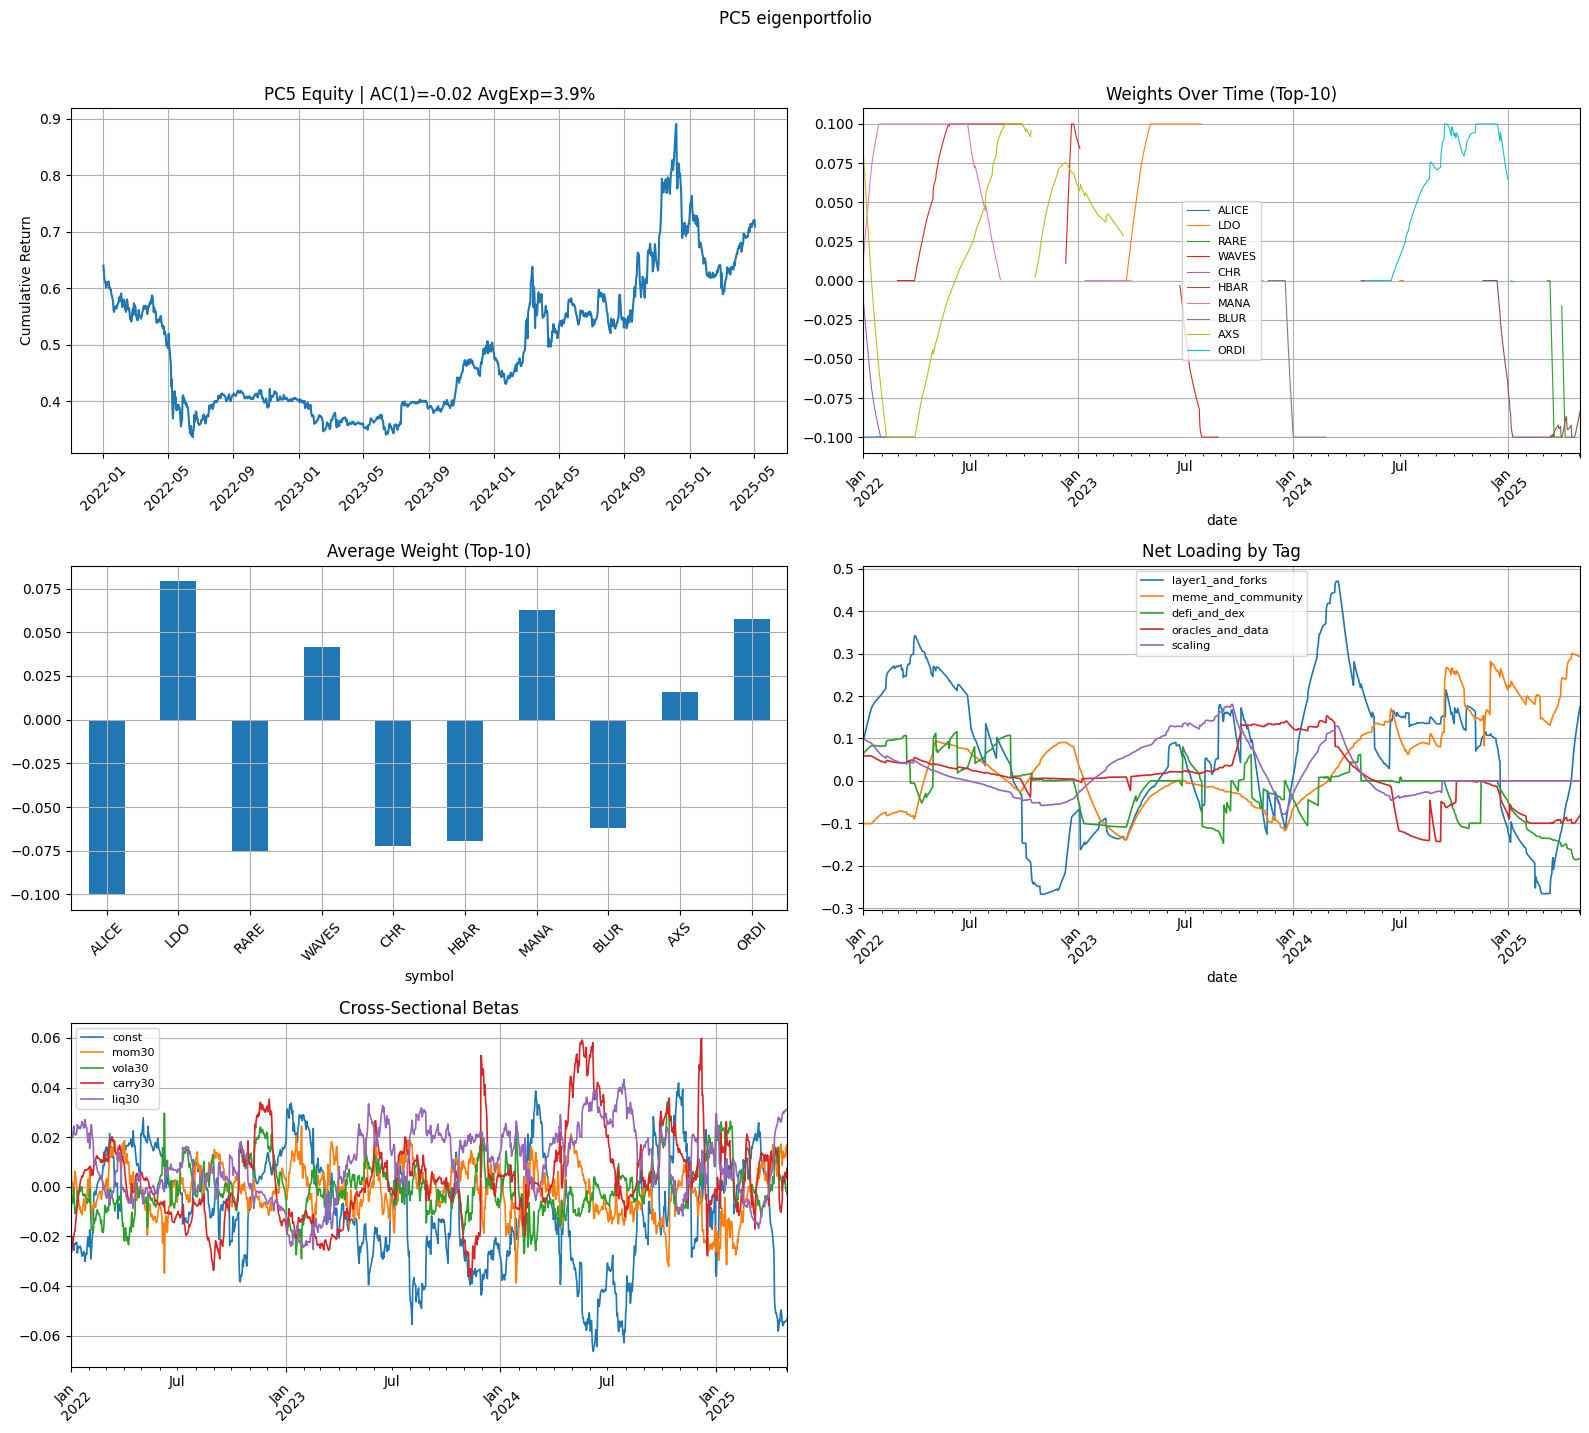

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# 0. LOAD & PREP DATA
# ----------------------------------------
# df = pd.read_csv("your_data.csv")
# tags_2.csv must hold columns: coin,tag

df = df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date']      = df['timestamp'].dt.normalize()

tags = pd.read_csv('./tags_2.csv', index_col='coin')['tag']

daily_close  = df.groupby(['date', 'symbol'])['close'].last().unstack('symbol')
daily_volume = df.groupby(['date', 'symbol'])['volume'].sum().unstack('symbol')
daily_dv     = daily_close * daily_volume
slowed_dv    = daily_dv.ewm(span=60).mean()
rets         = daily_close.pct_change(fill_method=None).dropna(how='all')

# ----------------------------------------
# 1. 30‑DAY STYLE FEATURES  (z‑scored, clipped ±3 by date)
# ----------------------------------------
def cs_zscore_clip(frame: pd.DataFrame, clip=3):
	mu = frame.mean(axis=1)
	sig = frame.std(axis=1, ddof=0).replace(0, np.nan)
	z = frame.sub(mu, axis=0).div(sig, axis=0)
	return z.clip(-clip, clip)

mom30_raw  = daily_close / daily_close.shift(30) - 1
vol30_raw  = rets.rolling(30).std()
fund_raw   = df.groupby(['date', 'symbol'])['fundingRate'].mean().unstack('symbol')
fund30_raw = fund_raw.rolling(30).mean()
liq30_raw  = np.log(daily_dv.rolling(30).mean()).replace([-np.inf, np.inf], np.nan)

mom30  = cs_zscore_clip(mom30_raw)
vol30  = cs_zscore_clip(vol30_raw)
fund30 = cs_zscore_clip(fund30_raw)
liq30  = cs_zscore_clip(liq30_raw)

style_features = {'mom30': mom30, 'vola30': vol30,
				  'carry30': fund30, 'liq30': liq30}

dates, tickers = rets.index, rets.columns

# ----------------------------------------
# 2. GLOBAL PARAMS
# ----------------------------------------
pcs           = range(1, 6)
top_n         = 30
lookback      = 200
smoothing_hl  = 20
cov_halflife  = 160
alpha         = 1 - 0.5 ** (1 / smoothing_hl)
cap           = 0.1
freeze_days   = 90
min_cov       = 0.9
plot_start    = pd.Timestamp('2022-01-01')

# ----------------------------------------
# 3. HELPERS
# ----------------------------------------
def align_sign(a, b):
	common = a.index.intersection(b.index)
	return -a if (common.size and (a.loc[common] @ b.loc[common]) < 0) else a

def ewma_cov(arr, halflife):
	lam = 0.5 ** (1 / halflife)
	w   = lam ** np.arange(arr.shape[0] - 1, -1, -1, dtype=float)
	w  /= w.sum()
	mean = np.average(arr, axis=0, weights=w)
	xc   = arr - mean
	return (w[:, None] * xc).T @ xc

def ols_coeffs_safe(y_vec, X_mat):
	mask = np.isfinite(y_vec) & np.isfinite(X_mat).all(axis=1)
	y, X = y_vec[mask], X_mat[mask]
	if len(y) <= X.shape[1]:               # not enough obs
		return np.full(X.shape[1] + 1, np.nan)
	X_ = np.column_stack([np.ones(len(X)), X])
	return np.linalg.pinv(X_) @ y

# ----------------------------------------
# 4. CORE
# ----------------------------------------
def compute_factor(pc_num):
	pc_idx      = pc_num - 1
	anchor_vec  = None
	anchor_idx  = -1
	last_comp   = None
	weights     = pd.DataFrame(np.nan, index=dates, columns=tickers)
	explained   = {}
	betas_store = {}

	for i, date in enumerate(dates):
		if i == 0:
			continue

		window = dates[max(0, i - lookback + 1): i + 1]
		counts = rets.loc[window].count()
		elig   = counts[counts >= int(min_cov * len(window))].index
		if elig.empty:
			continue

		uni = slowed_dv.loc[:date].iloc[-1].loc[elig].nlargest(top_n).index
		if uni.size <= pc_idx:
			continue

		data = rets.loc[window, uni].fillna(0).to_numpy()
		cov  = ewma_cov(data, cov_halflife)

		if anchor_vec is None or (i - anchor_idx) >= freeze_days:
			vals, vecs = np.linalg.eigh(cov)
			order = vals.argsort()[::-1]
			comp = vecs[:, order][:, pc_idx]

			# VARIANCE-NORMALIZED STEP
			inv_cov = np.linalg.inv(cov)
			varnorm = inv_cov @ comp
			varnorm = varnorm / np.sum(np.abs(varnorm))  # normalize to gross 1

			anchor_vec = pd.Series(varnorm, index=uni)
			anchor_idx = i
			explained[date] = vals[order][pc_idx] / vals.sum()


		comp_now = anchor_vec.reindex(uni).fillna(0.0)

		if last_comp is not None:
			comp_now = align_sign(comp_now, last_comp)
		last_comp = comp_now.copy()

		# scale to leverage 1
		w = comp_now / comp_now.abs().sum()

		if i > 1:
			prev = weights.iloc[i - 1].fillna(0)
			w    = alpha * w + (1 - alpha) * prev.reindex(w.index).fillna(0)

		w = w / w.abs().sum()
		w = w.clip(-cap, cap)
		weights.loc[date, w.index] = w

		# regression block
		feats = {k: style_features[k].loc[date, w.index] for k in style_features}
		Xdf = (pd.concat(feats, axis=1)
			   .replace([np.inf, -np.inf], np.nan)
			   .dropna())
		y = w.loc[Xdf.index]
		if len(Xdf) > Xdf.shape[1] + 1:
			β = ols_coeffs_safe(y.values, Xdf.values)
			betas_store[date] = dict(zip(['const'] + list(feats), β))

	ret  = (weights.shift(1) * rets).sum(axis=1)
	eq   = (1 + ret).cumprod()
	expl = pd.Series(explained)
	betas = pd.DataFrame.from_dict(betas_store, orient='index')

	return weights, eq, expl, betas

# ----------------------------------------
# 5. PLOTTING
# ----------------------------------------
for pc in pcs:
	w, eq, expl_s, betas = compute_factor(pc)

	eq   = eq.loc[plot_start:]
	ret  = (w.shift(1) * rets).sum(axis=1).loc[plot_start:]
	ac1  = ret.autocorr(1)
	avgexp = expl_s.loc[plot_start:].mean() * 100 if not expl_s.empty else np.nan
	top10 = w.loc[plot_start:].abs().mean().nlargest(10).index

	tag_map = tags.reindex(w.columns).fillna('other')
	w_tag   = w.groupby(tag_map, axis=1).sum().loc[plot_start:]
	w_tag   = w_tag.loc[:, w_tag.abs().mean().nlargest(5).index]

	fig, axs = plt.subplots(3, 2, figsize=(16, 14))
	axs = axs.flatten()

	axs[0].plot(eq.index, eq.values)
	axs[0].set_title(f'PC{pc} Equity | AC(1)={ac1:.2f} AvgExp={avgexp:.1f}%')
	axs[0].set_ylabel('Cumulative Return')
	axs[0].grid(True)
	axs[0].tick_params(axis='x', rotation=45)

	w.loc[plot_start:, top10].plot(ax=axs[1], lw=0.8)
	axs[1].set_title('Weights Over Time (Top‑10)')
	axs[1].grid(True)
	axs[1].legend(fontsize=8)
	axs[1].tick_params(axis='x', rotation=45)

	w.loc[plot_start:, top10].mean().plot.bar(ax=axs[2])
	axs[2].set_title('Average Weight (Top‑10)')
	axs[2].grid(True)
	axs[2].tick_params(axis='x', rotation=45)

	w_tag.plot(ax=axs[3], lw=1.2)
	axs[3].set_title('Net Loading by Tag')
	axs[3].grid(True)
	axs[3].legend(fontsize=8)
	axs[3].tick_params(axis='x', rotation=45)

	if not betas.empty:
		betas.loc[plot_start:].plot(ax=axs[4], lw=1.2)
		axs[4].set_title('Cross‑Sectional Betas')
		axs[4].grid(True)
		axs[4].legend(fontsize=8)
		axs[4].tick_params(axis='x', rotation=45)

	fig.delaxes(axs[5])

	plt.suptitle(f'PC{pc} eigenportfolio', y=1.02)
	plt.tight_layout()
	plt.show()
